#Multivariate Outlier Detection: A Game Changer in Understanding Complex Systems

In the world of industrial data analysis, outlier detection stands as a crucial technique for highlighting the irregularities, such as suboptimal system operation, abnormal conditions, potential and actual faults, etc.

Unlike traditional univariate outlier detection, which examines each variable in isolation, multivariate outlier detection considers the interplay between different multiple variables to identify anomalies. This approach is not just different; it's often more insightful, particularly in complex systems like District Heating.

Univariate outlier detection, though useful, has its limitations. It analyzes data one variable at a time, missing the bigger picture. For instance, a sudden spike in heat energy demand in a district heating system might not be an anomaly if correlated with a significant drop in outside temperature. Univariate analysis would flag this as an outlier, disregarding the crucial context provided by other variables.

Imagine a district heating system that typically operates within a predictable range of heat energy demand. However, on certain days, the demand spikes unusually. A univariate analysis would flag these spikes as outliers. But, when we incorporate other variables like outside temperature, solar irradiance, and wind speed, a different story might emerge. On days with exceptionally low outside temperatures and high wind speeds, the heating demand naturally increases, even if it's outside the 'normal' range. Multivariate analysis recognizes this pattern and understands that, given the weather conditions, this spike in demand is not an outlier but a predictable response to environmental factors.

##What does anomaly detection mean for District Heating Systems?

District Heating System (DHS) plant operation refers to the automated or semi-automated management of water temperature and water flow in both the main plant and substation supply lines. This control is based on the overall demand for DHS and the prevailing weather conditions. The total DHS demand is considered by analyzing the transmitted energy per time period, as measured by the calorimeter at the return lines. Normally, this transmitted energy is correlated with the outside ambient temperature, which is used as a main control parameter in DHS plant operation.

DHS are designed to efficiently distribute heat to multiple buildings within a geographical area. Anomalies in data, such as sudden spikes or drops in energy consumption, can indicate inefficiencies or malfunctions in the system. Detecting these anomalies allows for timely intervention to optimize energy usage and minimize waste. Anomalies in data can highlight fluctuations in heating performance, which may result in customer complaints. Identifying and rectifying anomalies promptly enhances service quality and customer contentment. When looking for anomalies beyond the transmitted energy, data can reveal abnormalities in the performance of different components of DHS, such as boilers, pumps and pipes, which may be indicative of impending failures or maintenance needs. Anomaly detection techniques can be used to implement predictive maintenance strategies in district heating systems. By identifying anomalies in equipment or performance data, maintenance schedules can be optimized to reduce downtime and minimize costs. Detecting anomalies in sensor data or measurement errors helps maintain the accuracy and reliability of data used for decision-making and modeling.

In this article with code, we show how you can use different methods for multivariate detection of outliers in the case of data of transmitted heat energy in the selected substation of local District Heating System, where also outside ambient temperature is considered. The overall research aims at uncovering irregular or ineffective/inefficient plant operation, with a wider objective of identifying the opportunities for reducing the consumption of gas in central heating plant as well as the CO2 emission. The methods that will be implemented are Z-score (univariate, as a benchmark), Mahalanobis distances, Principal Component Analysis (PCA), Isolation Forest and Hotelling's T-squared test.

Let's bring on some code at this point. We map the Google drive so to achieve access to the datasets we will be using.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here are some imports, mostly standard ones plus specific methods for multivariate outlier detection and Plotly for interactive presentation of time series data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

from scipy.spatial.distance import mahalanobis
from scipy.stats import f
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import plotly.graph_objs as go
from plotly.subplots import make_subplots

## How District Heating Systems work?

In DHS, heat fluid flow takes place in primary and secondary lines, separated by the heat exchanger. The central heating plant generates hot water or steam as a heat carrier. This high-temperature fluid carries thermal energy from the plant to the various consumers, namely the substations. This is a primary supply line.

At the substation, the high-temperature fluid from the central plant passes through a heat exchanger. This heat exchanger is typically designed to transfer heat from the central fluid to a separate, closed-loop system, from primary to secondary supply line. In the closed-loop system, the fluid is pumped to the individual customer's heating system (through branches). This closed loop prevents the central heating fluid from mixing with the customer's internal system.

After transferring its heat to the customer's closed-loop system, the temperature of the fluid in the substation decreases. This cooled fluid returns to the substation. This is a secondary return line. At the substation, the cooled fluid is reheated using heat from the central heating plant. The heat exchanger in the substation facilitates this process. Transmitted heat energy is measured at the calorimeter which is located at the primary return line. This energy is proportional to the difference between temperatures in secondary supply and return lines and flow in a secondary line.

Traditional DHSs are currently governed by a Supervisory Control And Data Acquisition (SCADA) system. This system incorporates various sensors, control mechanisms, and integrated algorithms that adjust operational parameters based on sensor readings. The control of DHS is entirely automated, encompassing both the boiler plant and the district heating substation levels. It also involves the implementation of suitable hot water reset control strategies, such as outdoor air reset or control curves, often represented by a regulation curve with multiple control set points (see Figure below).

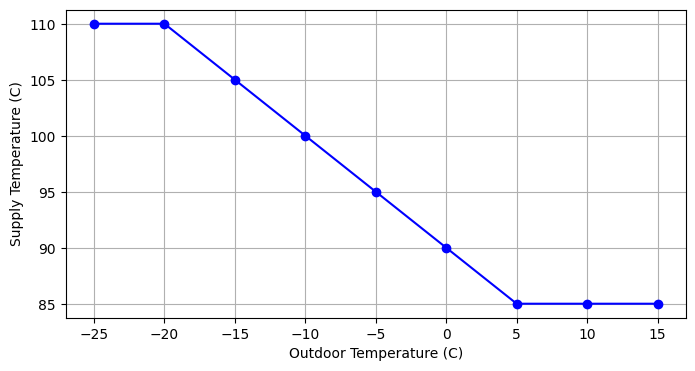

In [3]:
outdoor_temperatures = np.array([-25, -20, -15, -10, -5, 0, 5, 10, 15])
supply_temperatures = np.array([110, 110, 105, 100, 95, 90, 85, 85, 85])
plt.figure(figsize=(8, 4))
plt.plot(outdoor_temperatures, supply_temperatures, marker='o', linestyle='-', color='blue')
plt.xlabel('Outdoor Temperature (C)')
plt.ylabel('Supply Temperature (C)')
plt.grid(True)
plt.show()

One daily operation is expected to follow the specific pattern. This pattern includes the peaks that are the result of the operator decisions and valleys which occur when the heating system is off. To avoid detection of above-mentioned peaks as anomalies, in our approach we detect anomalies on the number of datasets, for which data included only transmitted energy and ambient temperature at the given hour. For example, we will separately analyze all data collected at 7:00 and at other hours.

The approach is used on the data corresponding to the specific hours due to a very clear seasonality daily pattern for the transmitted heat energy corresponding to the human operator procedures. The outlier detection approaches will be tested on the daily time series comprising of the ambient temperature and transmitted heat energy at the following hours of a day: 7, 8, 9, 10, 11, 12, 13, 14, 22, 23. Detection will consider both time series, so the bivariate outlier detection approach will be used. Multivariate outliers are data points that are unusual or extreme when considering multiple variables simultaneously. In other words, these are observations that are outliers in a multivariate space. As a reference, a simple statistical Z-score method will be used on transmitted heat energy signal.

## What data we get from SCADA?

The dataset we are going to work with includes following relevant features:

- Outside air temperature, acquired by the sensor in the substation (C, tsp)
- Reference temperature (C, trt). Reference temperature is a target temperature at secondary supply line which needs to be reached. Reference temperature is calculated by the control curve.
- Water temperature in the secondary supply line (C, tns)
- Water temperature in the secondary return line (C, tps)
- Water temperature in the primary supply line (C, tnp)
- Water temperature in the primary return line (C, tpp)
- Heat energy transmitted (MWh, e)

Data is collected from one substation 9 of the local DHS. The data period is 2018-05-05 - 2023-05-01, but for the sake of clarity and simplicity, we are going to look only at one heating season - 2018/2019.

Normally, the adopted time of the heating season start is the time of first change in transmitted heat energy after October 1st. The end of the heating season is normally April 15th. Although the heating system often remains operational after that date, till May 3rd, this data is discarded because of high temperature peaks that often occur in this period. Heat energy is measured at the calorimeter which is located at the primary supply line.

Due to special conditions for DHS operation in October, this month will also be omitted from the analysis. So, finally, for data analysis, the adopted period is 11-01 - 04-01.

In [4]:
datapath_processed='/content/drive/MyDrive/Projects/FondZaNauku/Prizma/Research/Data/p9_processed_2.csv'

In [5]:
df=pd.read_csv(datapath_processed)
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('Unnamed: 0',inplace=True)

df = df[(df.index < '2019-04-01')]
df['deltae']=(df['e'].shift(-1)-df['e'])*1000
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3618 entries, 2018-11-01 06:00:00 to 2019-03-31 23:00:00
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time_ref  3592 non-null   float64
 1   tsp       3592 non-null   float64
 2   trt       3592 non-null   float64
 3   tns       3592 non-null   float64
 4   tps       3592 non-null   float64
 5   tnp       3592 non-null   float64
 6   tpp       3592 non-null   float64
 7   e         3592 non-null   float64
 8   deltae    3570 non-null   float64
dtypes: float64(9)
memory usage: 282.7 KB


<ipython-input-5-27660e17e5be>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deltae']=(df['e'].shift(-1)-df['e'])*1000


Obviously, there is some missing data for transmitted energy, implying that our calorimeter was not responsive at some times. Let's not touch this yet.

##Bring on the tools

So, let's talk about the methods for outlier detection.

Z-score as the simplest but often most often univariate outlier detection technique will be used as a reference. Z-score is a statistical measure that quantifies how far is a data point from the mean of the dataset in terms of standard deviations.

$Z = \frac{X - \mu}{\sigma}$

Where:
- Z - z-score.
- X - individual data point you want to standardize.
- μ - mean (average) of the dataset.
- σ - standard deviation of the dataset.

Z-score is commonly used in detection of outliers (univariate analysis) in the dataset, by applying the arbitrarily selected thresholds. Selection of threshold has crucial effect on the reliability of the outlier detection and it should be done by the domain expert. Also, such technique is sensitive to the data distribution; Z-scores assume that the data is normally distributed as they are using mean as a reference. Z-scores are sensitive to skewness (asymmetry) and kurtosis in the data. In the presence of significant skewness or heavy tails, z-scores may misclassify some data points as outliers or fail to identify true outliers. Finally, Z-scores assume that data points are independent of each other. If data points are correlated or exhibit serial dependence (e.g., time series data), z-scores may not be appropriate. However, the negative effect of cross-correlation in time series data may be mitigated by using derivatives instead of the actual datapoint values.

Below you can find a function we will be using for calculating Z-score on our data. Note that we dropped the rows with missing values.

In [6]:
def getOutliersZScore(df, threshold):
  df=df[['tsp','deltae']]
  df.dropna()

  d=df['deltae']

  z_scores = np.where(d != 0, (d - np.mean(d[d != 0])) / np.std(d[d != 0]), np.nan)
  z_scores=np.abs(z_scores)
  outliers = df[abs(z_scores) > threshold][['tsp', 'deltae']]
  return outliers

Multivariate outliers are data points that are outliers not in a single variable (univariate outlier) but rather in a multivariate context. Multivariate outliers are detected by considering the relationships between two or more variables. A data point may not be considered an outlier when examining any individual variable but becomes an outlier when analyzing the combination of variables.

Multivariate outliers are important to identify because they can distort statistical analyses, affect the accuracy of predictive models, or carry unique information that researchers may want to investigate further. In the research presented in this paper, the following methods for multivariate (in this case, bivariate) outlier detection are: Mahalanobis distance, Principal Component Analysis (PCA), Isolation Forest and Hotelling's T-squared test. They are described in the remainder of this section.

###Mahalanobis Distance

Mahalanobis Distance is a method used for multivariate outlier detection. It is a measure of the distance between a data point and the center of a dataset in a multidimensional space, taking into account the variability and correlations of the data.

$D(X) = \sqrt{(X - \mu)^T \Sigma^{-1} (X - \mu)}$

where,
- $X$ represents the multivariate data point.
- $\mu$ is the mean vector.
- $\Sigma$ is the covariance matrix.
- $\Sigma^{-1}$ is the inverse of the covariance matrix.

Mahalanobis Distance is robust to data with different scales and units. It can capture correlations and dependencies between variables and it is applicable to high-dimensional datasets. One of the limitations of the method is that it assumes that the data follow a multivariate normal distribution, which may not always be the case.

The function for getting the outliers based on the Mahalnobis distances and given threshold is below. Note that we use tsp and deltae features to detect outliers.

In [7]:
def getOutliersMahalanobisDistances(df, threshold):

  df=df[['tsp','deltae']]
  df.fillna(0, inplace=True)

  deltae_data = df['deltae'].values
  tsp_data = df['tsp'].values
  data = np.column_stack((deltae_data, tsp_data))
  mean = np.nanmean(data, axis=0)
  stddev = np.nanstd(data, axis=0)
  normalized_data = (data - mean) / stddev

  nan_mask = np.isnan(normalized_data).any(axis=1)
  zero_mask = (normalized_data == 0).all(axis=1)
  remove_mask = nan_mask | zero_mask
  filtered_normalized_data = normalized_data[~remove_mask]
  normalized_data=filtered_normalized_data

  cov_matrix = np.cov(normalized_data, rowvar=False)

  mahalanobis_distances = [mahalanobis(point, mean, np.linalg.inv(cov_matrix)) for point in normalized_data]
  mahalanobis_distances_zscores = [(x - np.mean(mahalanobis_distances)) / np.std(mahalanobis_distances) for x in mahalanobis_distances]
  outliers_multivariate = [i for i, distance in enumerate(mahalanobis_distances) if mahalanobis_distances_zscores[i] > threshold]

  dhr=df.reset_index()
  dhr.rename(columns={'index': 'DatetimeIndex'}, inplace=True)
  dhr = dhr[dhr.index.isin(outliers_multivariate)]
  dhr['Unnamed: 0'] = pd.to_datetime(dhr['Unnamed: 0'])
  dhr.set_index('Unnamed: 0',inplace=True)
  dhr = dhr[dhr['deltae'] != 0]
  return dhr[['tsp', 'deltae']]

### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique used in multivariate outlier detection. While PCA is primarily known for dimensionality reduction and data compression, it can also be applied to identify outliers in multivariate datasets.

PCA's primary goal is to transform a dataset with multiple correlated variables (features) into a new set of uncorrelated variables called principal components. These components are linear combinations of the original features and capture most of the variance in the data. In PCA, the first few principal components capture the majority of the variance in the dataset, while subsequent components capture less and less. Therefore, the first few components contain the most valuable information about the data. Outliers in a multivariate dataset tend to exhibit significant deviations from the norm along one or more dimensions or combinations of dimensions. By reducing the dimensionality of the data with PCA, outliers can become more apparent in the reduced-dimensional space.

PCA can be used in combination with Mahalanobis Distance to detect multivariate outliers. After applying PCA, the Mahalanobis Distance is calculated for each data point in the reduced-dimensional space.

PCA is particularly useful when dealing with high-dimensional data because it reduces the dimensionality while retaining most of the important information. It can capture complex relationships and correlations among variables, making it suitable for identifying outliers with multivariate dependencies. PCA assumes that the data follow a Gaussian distribution, which may not always hold true for all datasets.

Using function below to extract outliers by using PCA.

In [8]:
def getOutliersPCA(df, threshold, components):

  df=df[['tsp','deltae']]
  df.dropna()

  features = ['tsp','deltae']

  nan_mask = df.isna().any(axis=1)
  zero_mask = (df == 0).all(axis=1)
  exclude_mask = nan_mask | zero_mask
  X = df[~exclude_mask]

  X = df[features]
  X.fillna(0, inplace=True)

  scaler = StandardScaler()
  X_std = scaler.fit_transform(X)
  pca = PCA(n_components=components)
  pca.fit(X_std)
  X_pca = pca.transform(X_std)
  mahalanobis_distance = np.sqrt(np.sum(X_pca**2, axis=1))

  outliers_pca = df[mahalanobis_distance > threshold]
  outliers_pca = outliers_pca[outliers_pca['deltae'] != 0]
  return outliers_pca

### Isolation Forest

The Isolation Forest is an ensemble machine learning algorithm used for outlier detection. It operates by randomly selecting a feature and a random split point for that feature. It does this recursively until it isolates an outlier or reaches a specified depth in the tree. The algorithm builds multiple isolation trees, also known as iTrees. Each iTree is constructed as follows:
- Randomly select a feature from the dataset.
- Randomly select a split value for the chosen feature within its range.
- Divide the data into two subsets: one with data points greater than the split value and one with data points less than the split value.
- Repeat the above steps recursively for each subset until a stopping criterion is met (e.g., maximum tree depth or a single data point is isolated).

For each data point, the Isolation Forest measures the average path length required to isolate the data point in the constructed iTrees.Shorter path lengths indicate that the data point is an outlier, as it required fewer splits to isolate it from the rest of the data.

The average path lengths for all data points are averaged across all iTrees. Data points with shorter average path lengths are considered anomalies (outliers), while those with longer average path lengths are considered normal (inliers).

The contamination parameter is used to control the proportion of expected outliers in the dataset. It represents the expected percentage of anomalies in the dataset. The contamination parameter controls the trade-off between precision and recall in outlier detection. A lower value results in stricter detection of outliers.

Some crucial advantages of IF are that it scales well to large datasets, it is capable of identifying anomalies in high-dimensional data, with relatively small tuning effort. Finally, it doesn't require assumptions about the data distribution.

However, there are some limitations. Isolation Forest assumes that anomalies are sparse and can be isolated with fewer splits. While this is often true for many datasets, it may not be the case for all. In some datasets, anomalies may not be isolated efficiently by random partitioning. The method is sensitive to sampling. Isolation Forest relies on random sampling, which can lead to variation in results. Different random samples can produce slightly different isolation trees and, consequently, different outlier scores. The method does not consider data relationships. Isolation Forest treats features independently and doesn't consider the relationships or correlations between features. In some cases, outliers may only be detected by considering multivariate relationships. Thus, it is primarily designed for detecting individual outliers rather than identifying clusters of anomalies. Furthermore, the method is sensitive to data scaling. It is important to preprocess the data appropriately, especially when features have different scales. The explainability is a challenge: Isolation Forest doesn't provide explanations or reasons for why a particular data point is considered an outlier. It only assigns anomaly scores based on path lengths in the trees.

The function is below.

In [9]:
def getOutliersIsolationForest(df, contamination):
  features = ['tsp', 'deltae']
  df=df[features]
  df.fillna(0, inplace=True)
  model = IsolationForest(contamination=contamination)
  model.fit(df)

  outliers = model.predict(df)
  df['is_outlier'] = outliers

  df = df[df['deltae'] != 0]
  df = df[df['is_outlier'] == -1]
  return df[['tsp','deltae']]

### Hotelling's T-squared test

Hotelling's T-squared test is a statistical method used for multivariate outlier detection and analysis. It extends the concept of a two-sample t-test to the multivariate setting, making it suitable for identifying outliers or unusual patterns in multivariate data.

Hotelling's T-squared test is designed to identify whether there are significant differences between the means of multivariate datasets. It provides a statistical measure of how far an observation is from the mean of the dataset in a multivariate space. The test compares the Mahalanobis distance (a measure of distance that accounts for correlations between variables) of each observation from the multivariate mean to a critical value derived from the F-distribution.

Hotelling's T-squared test assumes that the data follows a multivariate normal distribution.

The alpha parameter in Hotelling's T-squared test refers to the significance level of the test. A lower alpha value means you are being more conservative and requiring stronger evidence to reject the null hypothesis.

Find the function below.

In [10]:
def getOutliersHotelling(df, alpha):
  df=df[['tsp','deltae']]
  df.fillna(0, inplace=True)
  X = df.values

  mean_vector = np.nanmean(X, axis=0)
  cov_matrix = np.cov(X, rowvar=False)

  n = len(X)
  p = X.shape[1]

  t_squared = np.zeros(n)
  for i in range(n):
    x_diff = X[i] - mean_vector
    t_squared[i] = np.dot(np.dot(x_diff, np.linalg.inv(cov_matrix)), x_diff)

  df1 = p
  df2 = n - p - 1

  critical_value = f.ppf(1 - alpha, df1, df2)

  outliers = np.where(t_squared > critical_value)[0]

  dhr=df.reset_index()
  dhr.rename(columns={'index': 'DatetimeIndex'}, inplace=True)
  dhr = dhr[dhr.index.isin(outliers)]
  dhr['Unnamed: 0'] = pd.to_datetime(dhr['Unnamed: 0'])
  dhr.set_index('Unnamed: 0',inplace=True)
  dhr = dhr[dhr['deltae'] != 0]

  return dhr

## So, is our data normally distributed?

Bivariate detection of outliers is carried out on transmitted energy and outside temperature, where the latter is shifted one timestep in the future, because the decision on increasing the heat energy transmission in the next hour is made based on the temperature in the current hour. This is considered a reasonable simplification, because it assumes system inertia of 1 hour which is not actually correct. This simplification is made because only hourly series data is available for the period of analysis.

Both features are normally distributed which is very positive for great most of the methods for outlier detection which assume the Gaussian distribution. The exception is transmitted energy, where in many datapoints, no energy is being transmitted. This data will be omitted from the analysis of outliers as this is an indication that the plant does not transmit any heat energy.

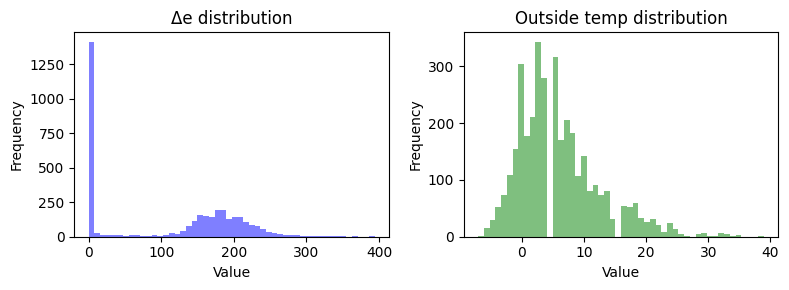

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].hist(df['deltae'], bins=50, alpha=0.5, color='blue')
axes[0].set_title('Δe distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['tsp'], bins=50, alpha=0.5, color='green')
axes[1].set_title('Outside temp distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##Let's run the outlier detection methods

Outliers are now detected by using the provided methods, by adopting the specific values for the methods' parameters. Before that, an hourly datasets are created.

In [16]:
hourly_datasets = []
hourly_outliers_deltae=[]
hourly_outliers_deltaetsp=[]
hourly_outliers_deltaetsp_pca=[]
hourly_outliers_deltaetsp_if=[]
hourly_outliers_deltaetsp_hotelling=[]

for hour in range(24):
  dataset_for_hour = df[df.index.hour == hour].copy()

  outliers = getOutliersZScore(dataset_for_hour, 1.96)
  outliers_md = getOutliersMahalanobisDistances(dataset_for_hour, 1)
  outliers_pca = getOutliersPCA(dataset_for_hour, 2.0, 1)
  outliers_if = getOutliersIsolationForest(dataset_for_hour, 0.018)
  outliers_hotelling = getOutliersHotelling(dataset_for_hour, 0.001)

  hourly_datasets.append(dataset_for_hour)
  hourly_outliers_deltae.append(outliers)
  hourly_outliers_deltaetsp.append(outliers_md)
  hourly_outliers_deltaetsp_pca.append(outliers_pca)
  hourly_outliers_deltaetsp_if.append(outliers_if)
  hourly_outliers_deltaetsp_hotelling.append(outliers_hotelling)

<ipython-input-7-6bef7d1e7fa9>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-be021f68e5f1>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names

<ipython-input-9-be021f68e5f1>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

Outliers are now plotted, in an overlay of transmitted heat and ambient temperature data per specific hour, for the specific method, for the specific heating season.

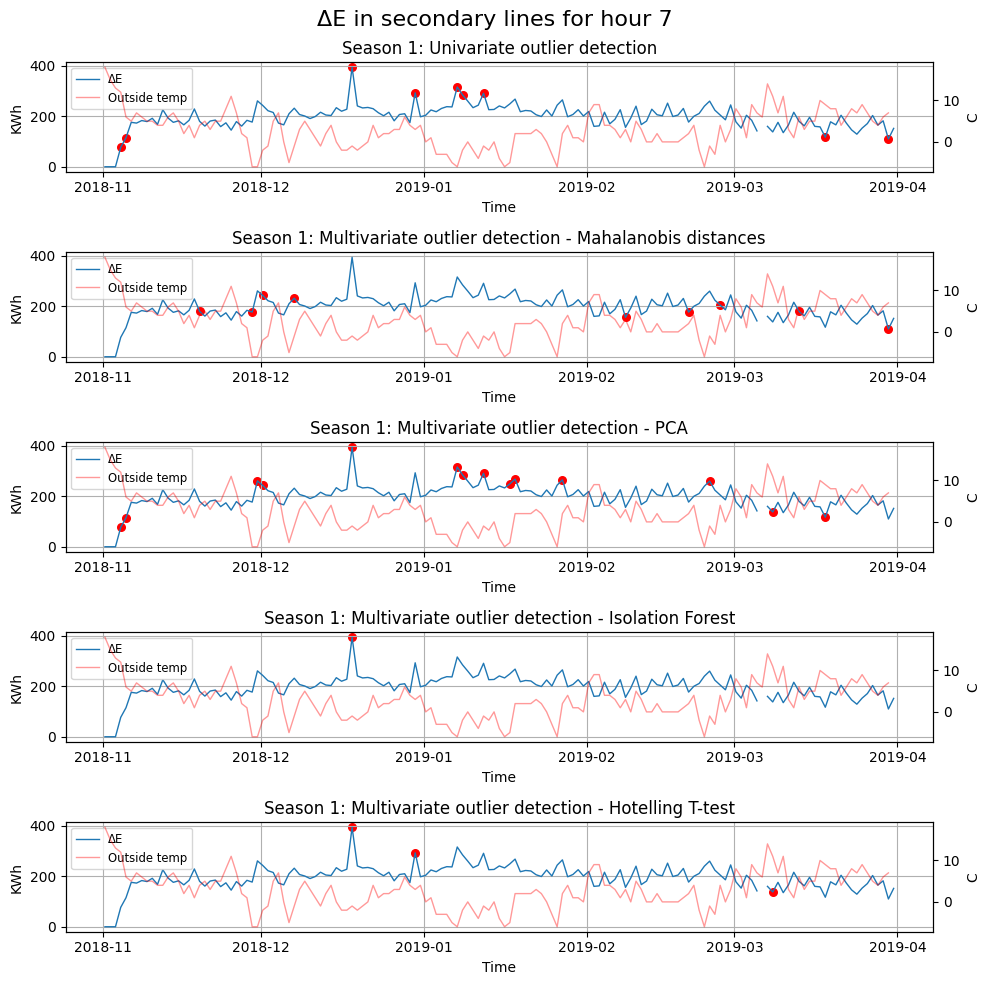

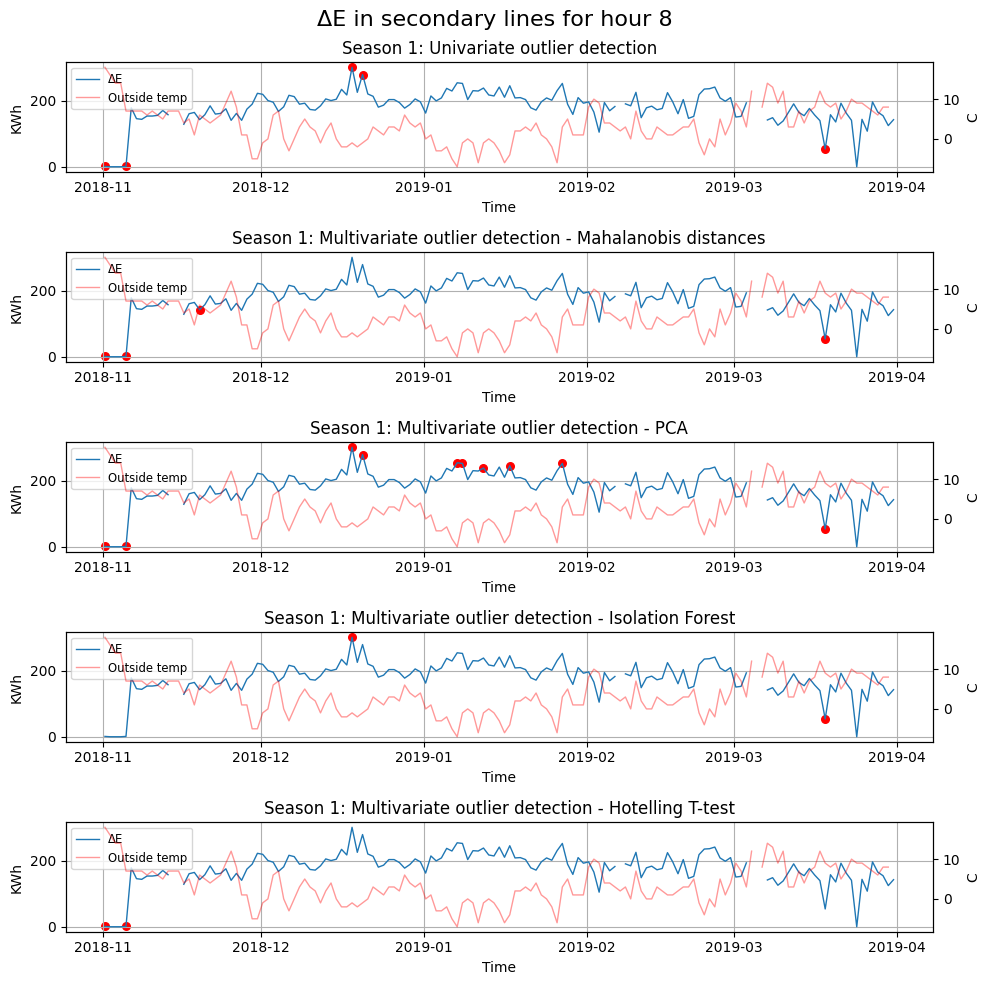

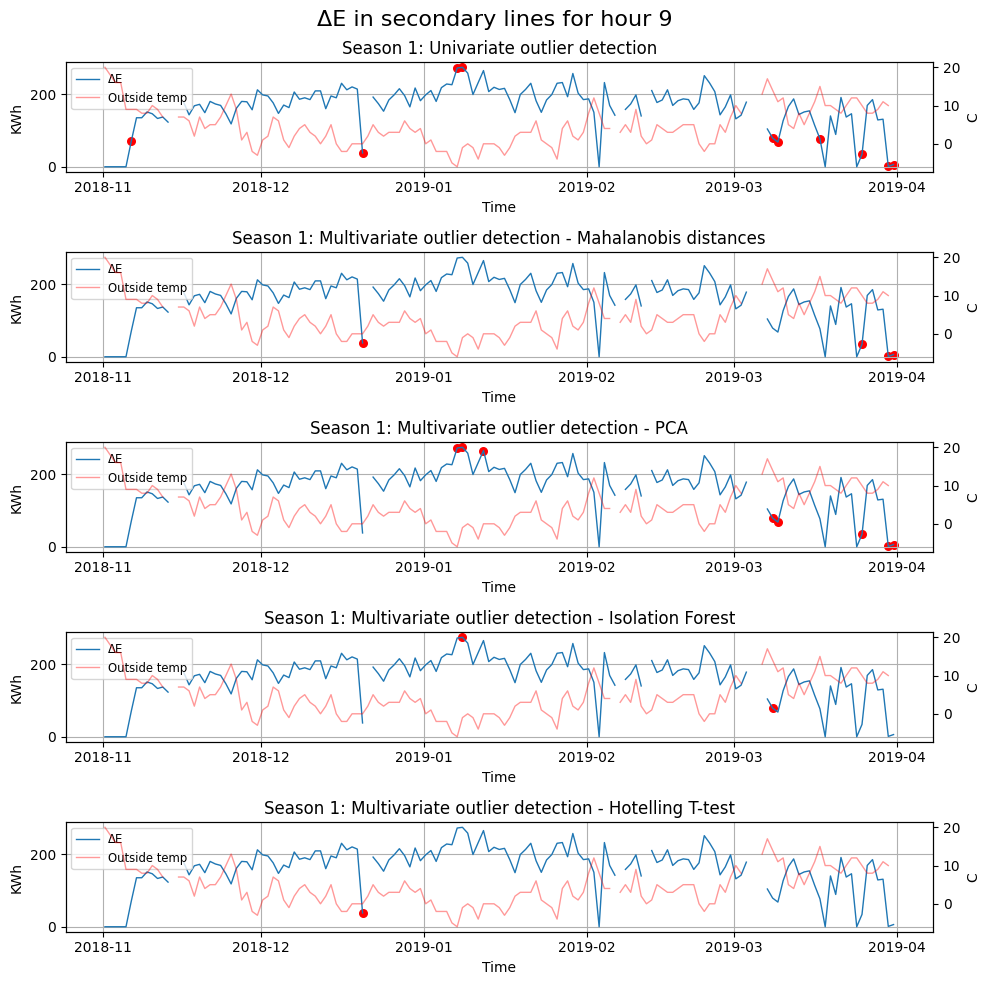

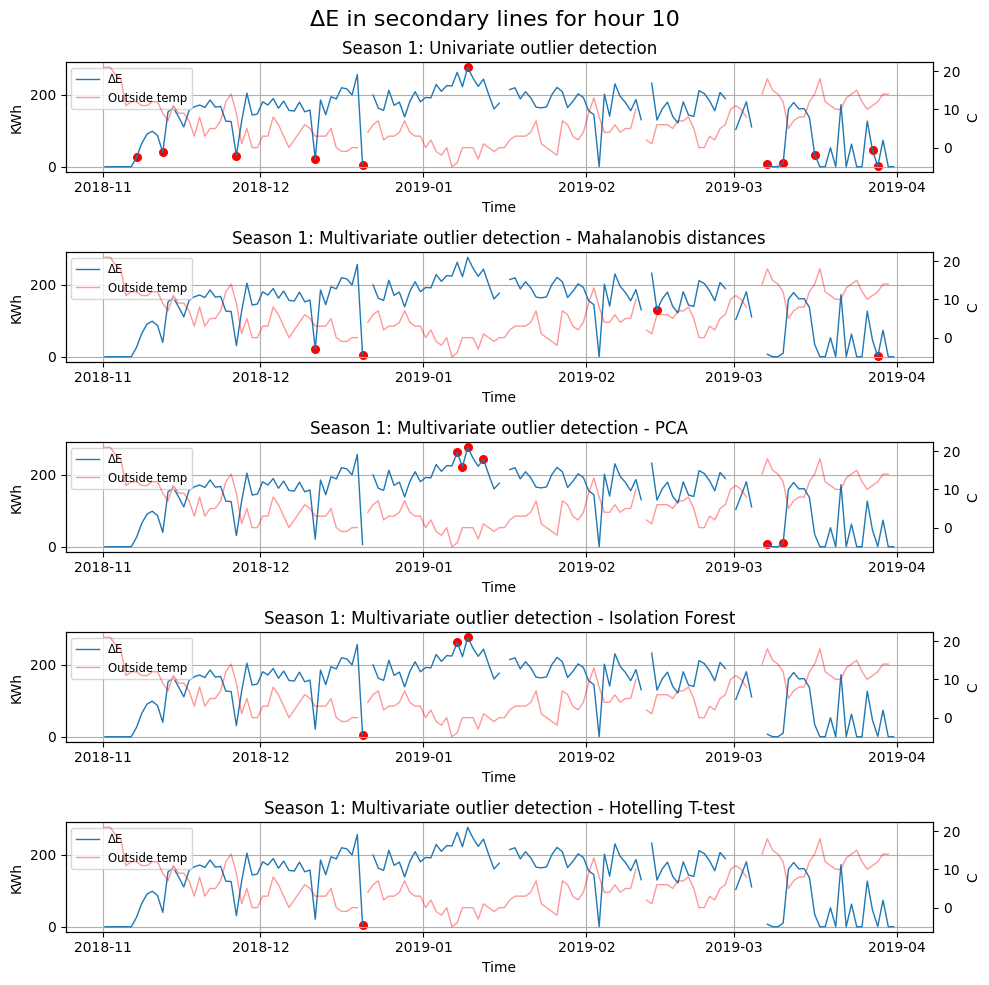

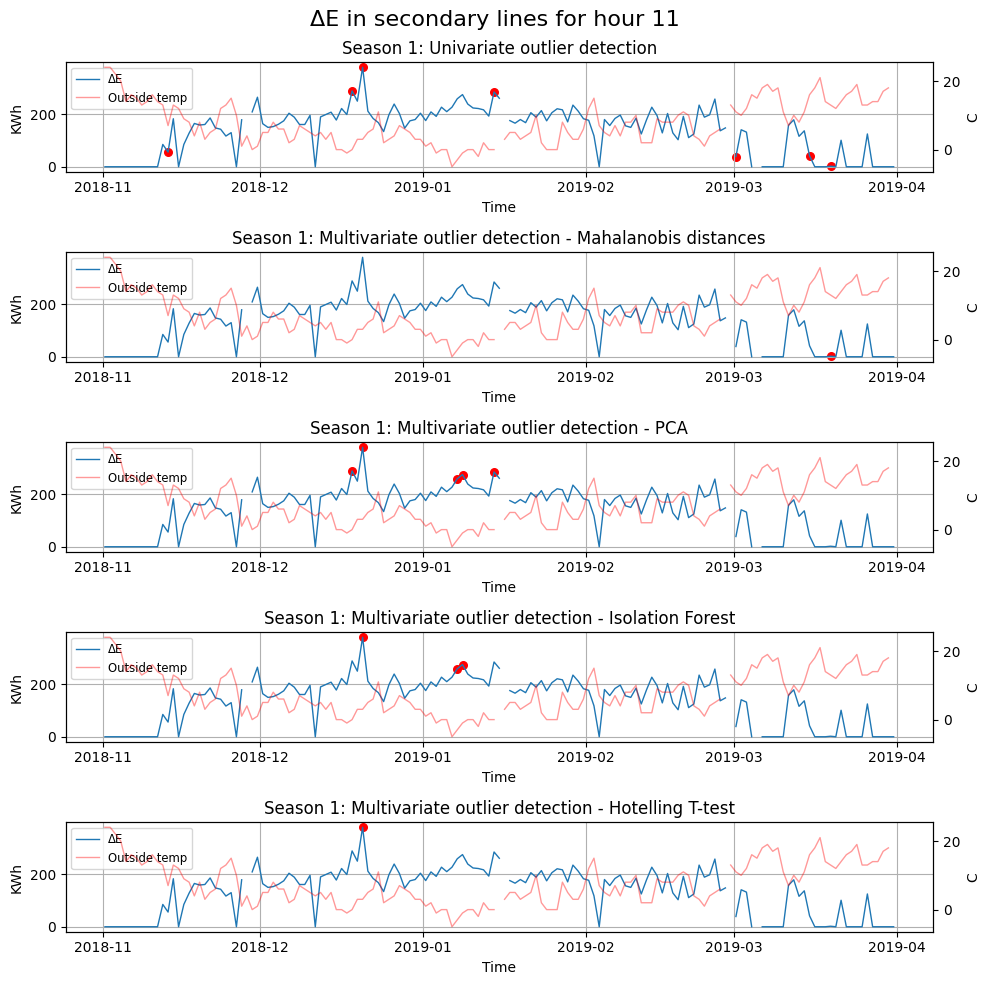

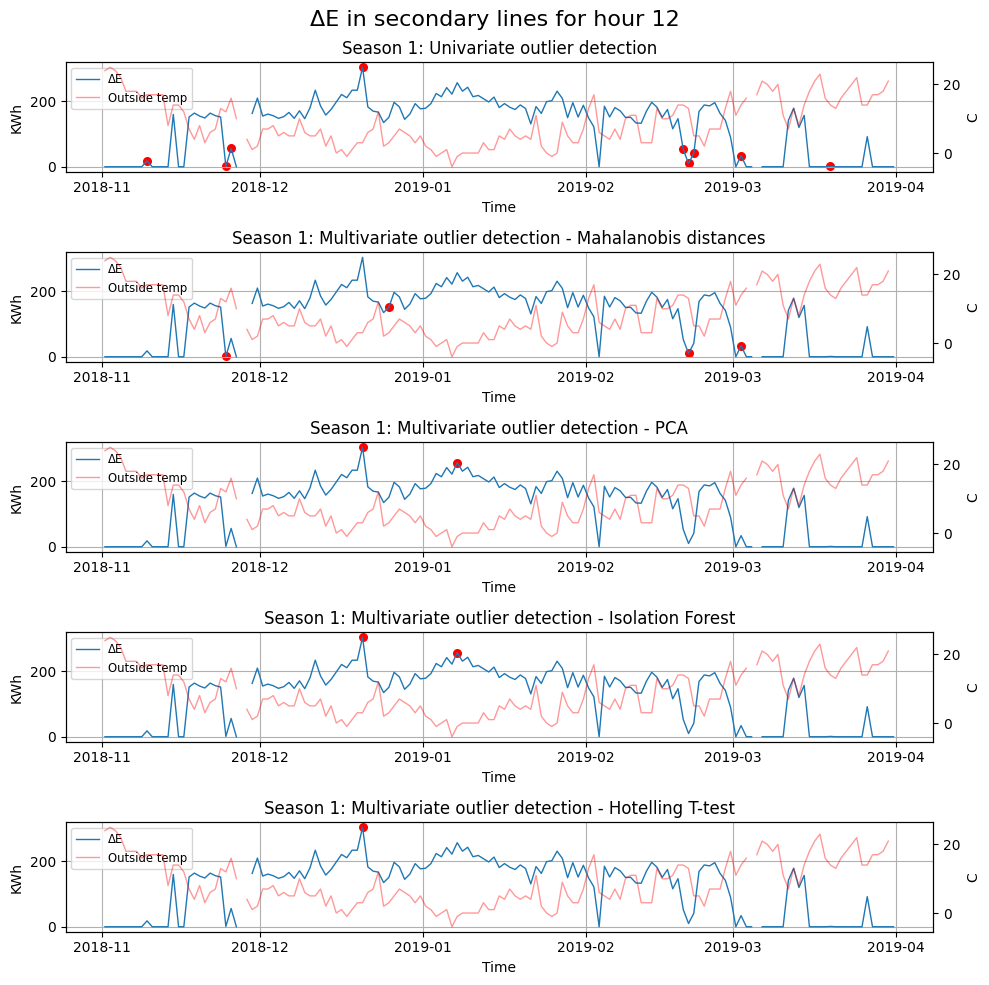

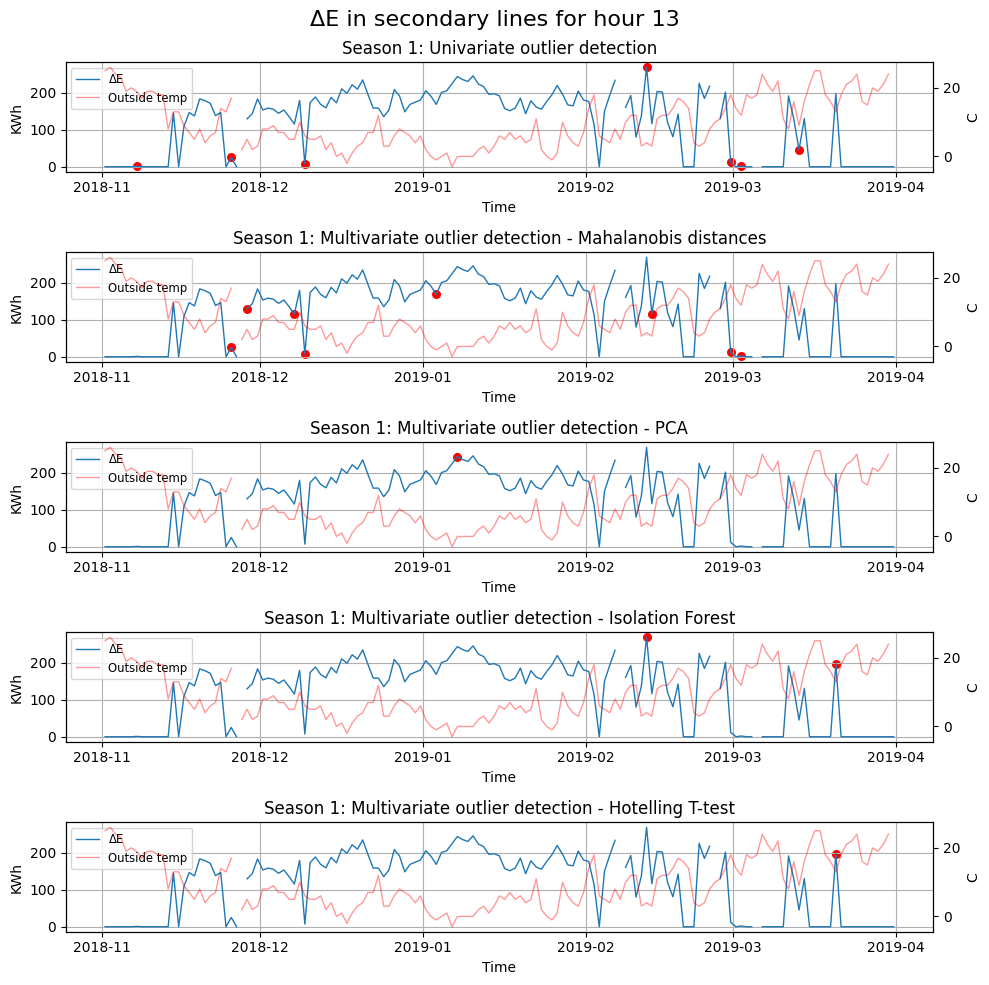

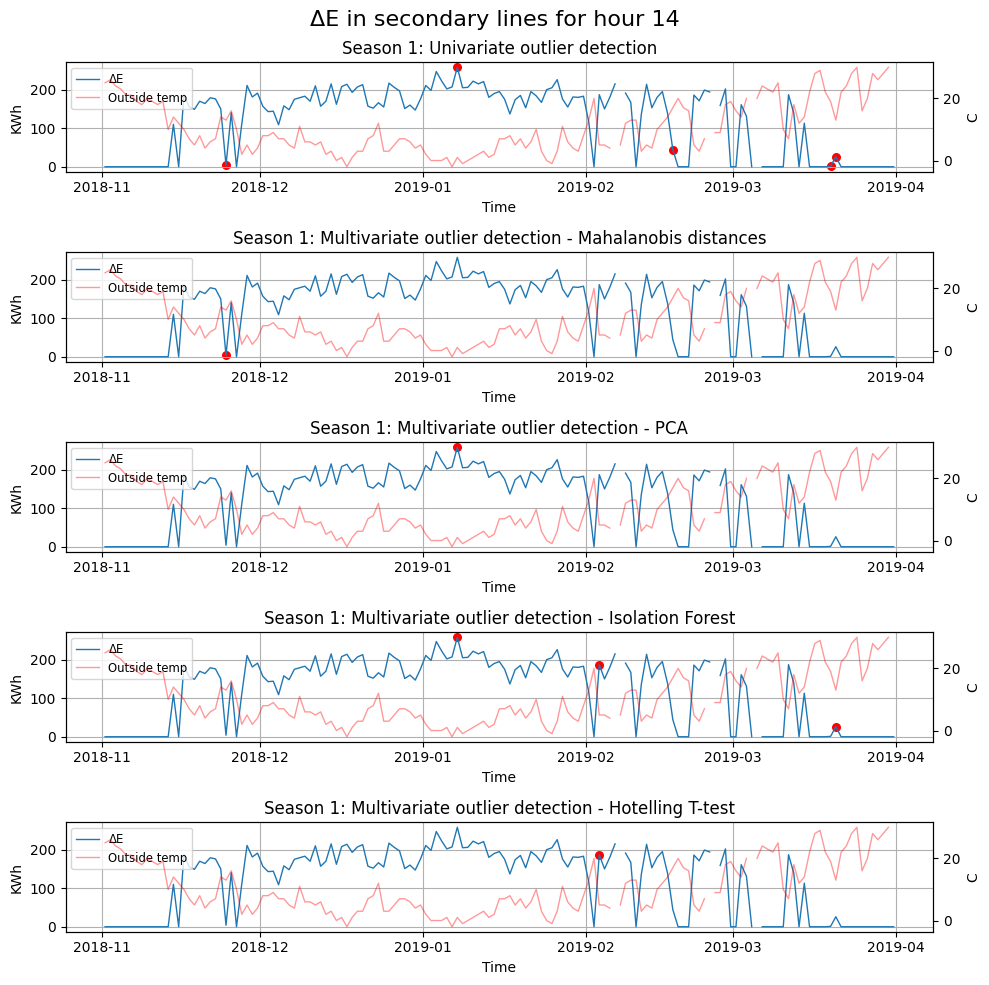

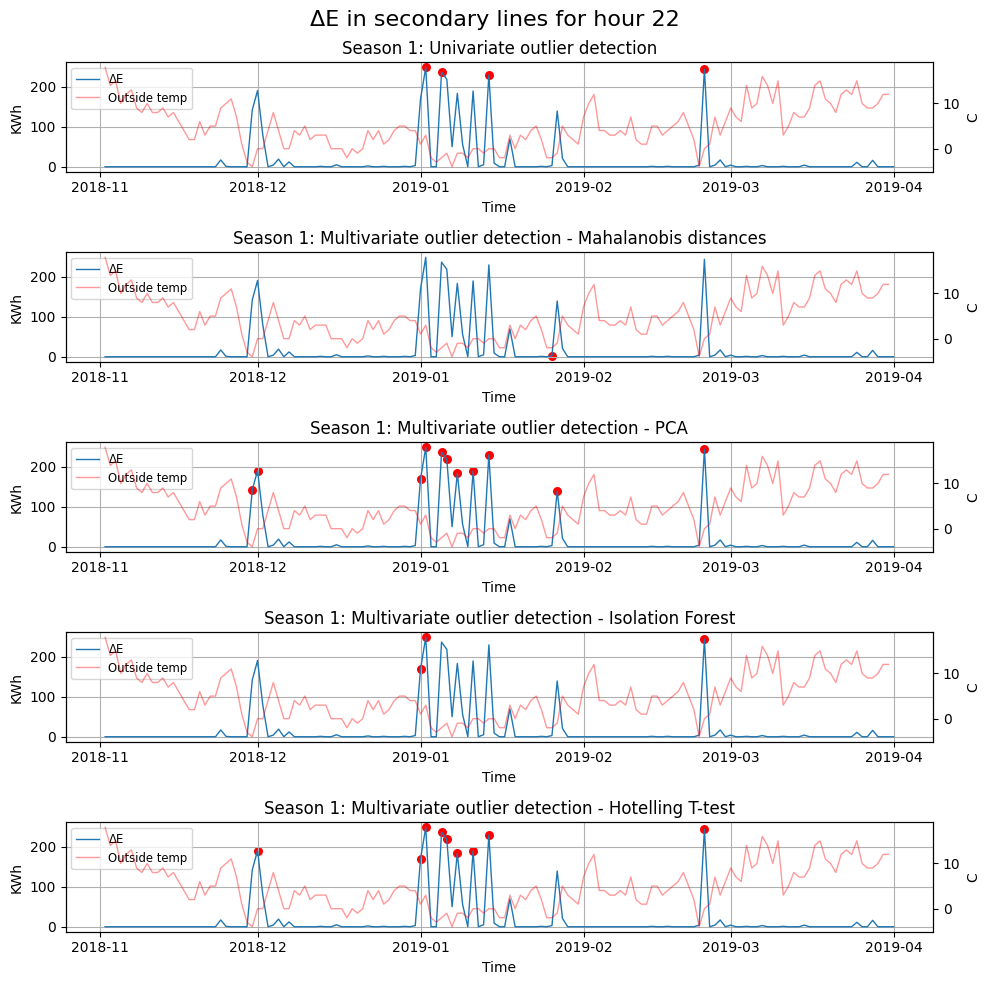

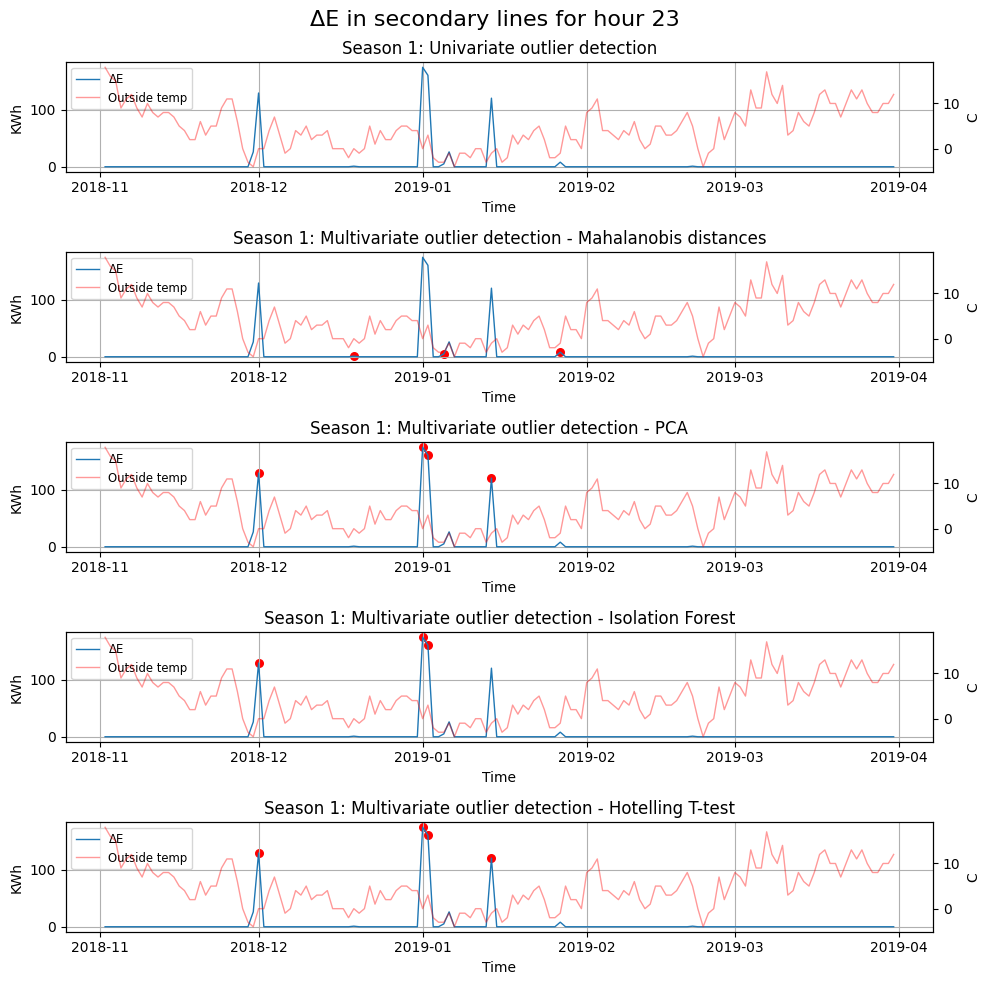

In [17]:
alloutliers=[hourly_outliers_deltae,
             hourly_outliers_deltaetsp,
             hourly_outliers_deltaetsp_pca,
             hourly_outliers_deltaetsp_if,
             hourly_outliers_deltaetsp_hotelling
             ]

titles=['Univariate outlier detection',
        'Multivariate outlier detection - Mahalanobis distances',
        'Multivariate outlier detection - PCA',
        'Multivariate outlier detection - Isolation Forest',
        'Multivariate outlier detection - Hotelling T-test'
]

for hour, dataset in enumerate(hourly_datasets):
 if((hour>6 and hour<15) or hour>21):
  fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))
  fig.suptitle("ΔE in secondary lines for hour "+str(hour), fontsize=16)
  for i,o in enumerate(alloutliers):

    line1,=axs[i].plot(dataset[dataset.index < pd.to_datetime('2019-04-10')].index, dataset[dataset.index < pd.to_datetime('2019-04-10')]['deltae'], linewidth='1', label='ΔE')
    axs[i].scatter(o[hour][o[hour].index < pd.to_datetime('2019-04-10')]['deltae'].index, o[hour][o[hour].index < pd.to_datetime('2019-04-10')]['deltae'], c='red', marker='o', s=30, label='Outliers')
    ax2=axs[i].twinx()
    ax2.set_ylabel('C')
    line2,=ax2.plot(dataset[dataset.index < pd.to_datetime('2019-04-10')].index, dataset[dataset.index < pd.to_datetime('2019-04-10')].shift(-1)['tsp'], linewidth='1', label='Outside temp', color='r', alpha=0.4)
    axs[i].set_title('Season 1: '+titles[i])
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel('KWh')
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    axs[i].legend(lines, labels, loc='upper left', fontsize='small')
    axs[i].grid(True)


  plt.tight_layout()
  plt.show()

All hourly datasets are now merged to construct the dataframes with all identified outliers per specific method.

In [18]:
all_outliers_deltae=pd.DataFrame()
all_outliers_deltaetsp=pd.DataFrame()
all_outliers_deltaetsp_pca=pd.DataFrame()
all_outliers_deltaetsp_if=pd.DataFrame()
all_outliers_deltaetsp_hotelling=pd.DataFrame()

for hour in [7, 8, 9, 10, 11, 12, 13, 14, 21, 22, 23]:
  all_outliers_deltae = pd.concat([all_outliers_deltae, hourly_outliers_deltae[hour]])
  all_outliers_deltaetsp = pd.concat([all_outliers_deltaetsp, hourly_outliers_deltaetsp[hour]])
  all_outliers_deltaetsp_pca = pd.concat([all_outliers_deltaetsp_pca, hourly_outliers_deltaetsp_pca[hour]])
  all_outliers_deltaetsp_if = pd.concat([all_outliers_deltaetsp_if, hourly_outliers_deltaetsp_if[hour]])
  all_outliers_deltaetsp_hotelling = pd.concat([all_outliers_deltaetsp_hotelling, hourly_outliers_deltaetsp_hotelling[hour]])

  all_outliers_deltae=all_outliers_deltae.sort_index()
  all_outliers_deltaetsp=all_outliers_deltaetsp.sort_index()
  all_outliers_deltaetsp_pca=all_outliers_deltaetsp_pca.sort_index()
  all_outliers_deltaetsp_if=all_outliers_deltaetsp_if.sort_index()
  all_outliers_deltaetsp_hotelling=all_outliers_deltaetsp_hotelling.sort_index()

Finally, plotly package is used to plot the ambient temperature and transmitted heat energy time series with overlayed outliers, as identified per specific method. Plotly generated plots are interactive, users can click and drag to zoom in the specific periods, for a better insight into the results of the methods.

In [19]:
alloutliers=[all_outliers_deltae,
             all_outliers_deltaetsp,
             all_outliers_deltaetsp_pca,
             all_outliers_deltaetsp_if,
             all_outliers_deltaetsp_hotelling
             ]

titles=['Univariate outlier detection',
        'Multivariate outlier detection - Mahalanobis distances',
        'Multivariate outlier detection - PCA',
        'Multivariate outlier detection - Isolation Forest',
        'Multivariate outlier detection - Hotelling T-test'
]

subplot_titles=titles




fig = make_subplots(
    rows=5,
    cols=1,
    specs=[
        [{"secondary_y": True}],
        [{"secondary_y": True}],
        [{"secondary_y": True}],
        [{"secondary_y": True}],
        [{"secondary_y": True}]
    ],
    vertical_spacing=0.07,
    horizontal_spacing=0.04,
    subplot_titles=subplot_titles

  )

for i,o in enumerate(alloutliers):
    i=i+1
    fig.add_trace(go.Scatter(x=df[df.index < pd.to_datetime('2019-04-10')].index,
                         y=df[df.index < pd.to_datetime('2019-04-10')]['deltae'],
                         mode='lines', name='ΔE', line=dict(color='blue', width=1), opacity=0.4), row=i, col=1, secondary_y=False)

    fig.add_trace(go.Scatter(x=o[o.index < pd.to_datetime('2019-04-10')]['deltae'].index,
                         y=o[o.index < pd.to_datetime('2019-04-10')]['deltae'],
                         mode='markers', marker_color='red', name='Outliers'), row=i, col=1, secondary_y=False)

    fig.add_trace(go.Scatter(x=df[df.index < pd.to_datetime('2019-04-10')].index,
                         y=df[df.index < pd.to_datetime('2019-04-10')].shift(-1)['tsp'],
                         mode='lines', name='Outside Temp', line=dict(color='red', width=1), opacity=0.4), row=i, col=1, secondary_y=True)


    fig.update_layout(height=1200, width=900, showlegend=False)
    fig.update_xaxes(title_text="Time", row=i, col=1)
    fig.update_yaxes(title_text="KWh", row=i, col=1, secondary_y=False)
    fig.update_yaxes(title_text="C", row=i, col=1, secondary_y=True)

for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 13
for i in range(1, 6):
    fig.update_yaxes(showgrid=False, secondary_y=True, row=i, col=1)

fig.show()

##How to check if we are doing a good job?

All the mentioned methods need to have some thresholds defined. Defining these values is somewhat of a subjective decision, and there is no universal way or guidelines to select these. We use good old trial and error with a lot of help from expert from the domain.

Yup, we did that, we asked the expert to look at what the different methods produced, so to help us to adopt the proper thresholds.

Once the expert deemed the results satisfactory, the thresholds were considered successful. However, despite the careful selection of thresholds, two methods yielded unsatisfactory results. The Univariate Outlier Detection method (Z-score) performed poorly, which was expected considering its focus on a single variable. Remember, this method was employed merely as a benchmark, and its suboptimal performance was expected. The other method presenting challenges was Mahalanobis Distances. Regardless of the threshold settings, the identified outliers did not meet the expected interpretability.

On average, the highest number of outliers appeared during the early morning hours (7h) and late-night hours (22h and 23h).

The increased number of outliers at 7h in the morning can be attributed to variations in the start time of the heating cycle by the operator at the heating plant. Sometimes the cycle begins a bit later, and occasionally, the operator decides it's unnecessary to initiate heating at that specific time. This variability is reflected in the higher number of outliers detected at 7h. Similarly, during late-night hours (22h or 23h), the need for heating fluctuates based on the outside temperature and the operator's estimations. There are instances where heating is deemed necessary and times when it is not, leading to a higher number of outliers during these hours (relative to the number of valid, non-zero deltae data).

In addition, at times in the morning (9-11h) there appeared to be either no output energy or a minimal amount, even when the outside temperatures are low, and the heating system should be active (see figure below). However, there is a straightforward explanation: during the early morning when the heating starts, the objective is to achieve the required temperature in the secondary supply line as fast as possible, to ensure customers receive adequate heating. Occasionally, too much energy is sent to the secondary supply line, causing the water temperature in that line to exceed the required level. Therefore, there is a significant reduction in the sent energy in the next hour(s), in order to lower the water temperature at the secondary line and thereby reach the required temperature level. While it was anticipated that the outlier detection methods might incorrectly label these segments as false positive outliers, the methods performed remarkably well by correctly recognizing that these instances are not outliers (see Figure below).

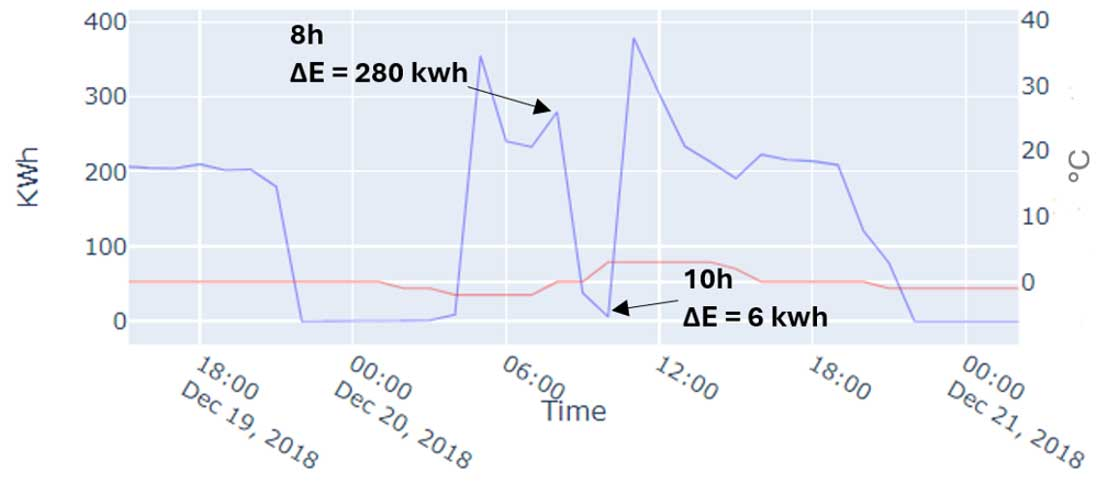

In [ ]:
filename='/content/drive/MyDrive/Projects/FondZaNauku/Prizma/Research/Anomaly detection/Images/Fig.-Sudden-decrease-of-sent-energy-to-the-secondary-supply-line,-due-to-the-exceeding-the-targeted-temperature-of-the-supply-line-in-the-previous-hours.jpg'
display(Image(filename=filename, width=800))

Figure: Sudden decrease of sent energy to the secondary supply line, due to the exceeding the targeted temperature of the supply line in the previous hours

## Conclusion

So, that's it, that's the story. Our experts were not super happy, but everything works as expected and there is so much space for improvement.

Where we are going to go from here, let's see:

- We are going to try the ensembles of the methods we use, so to introduce voting and maybe even grade the outliers (the idea is to develop the proper method and use it in the system for detecting anomalies).
- Speaking of ensembles, why not trying also some more complex stuff. We will test the effectiveness of the different boosting methods within the multivariate outlier detection problem. For example, PCA can be used to reduce the dimen-sionality to transform the multivariate to bivariate problem, where other methods can be used to solve it, such as Isolation Forest.
- We will be adding more features in a multivariate analysis, namely other relevant weather parameters, such as solar irradiance, wind strength and direction.
- The performance measurement of the conventional methods still remains the problem as it requires quite a significant effort by the experts who validate the results manually. Efficiency of the validation process, at least in the aspect of method comparison can be somewhat improved by implementing the dynamic selection of the values of parameters/thresholds for different methods based on the defined fixed number of outliers to be detected for all methods.
- Feasibility of the supervised anomaly detection approach will be investigated, based on expert annotated anomalies. Such an approach would enable explicit and direct performance measurement, and it will facilitate the explainability.
- Did anyone say Deep Learning? We are kinda old-school researchers, we don't take big guns until we are absolutely sure we touch the ceiling. But hey, when the times get rough..
- End goal: software application for walk-forward detection of outliers which are expected to pinpoint ineffective or inefficient heating as well as the fault detection.

Do you have an idea? Share it with us:
